<a href="https://colab.research.google.com/github/leahandofir/earthformer-inference-experiments/blob/main/earthformer_SEVIR_inference_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SEVIR dataset: https://nbviewer.org/github/MIT-AI-Accelerator/eie-sevir/blob/master/examples/SEVIR_Tutorial.ipynb 

Install dependecies

In [ ]:
!curl 'https://raw.githubusercontent.com/leahandofir/earthformer-inference-experiments/main/prerequisites.sh' -o ./prerequisites.sh
!bash ./prerequisites.sh

In [11]:
# checking the aws cli installation
!aws --version

aws-cli/2.11.19 Python/3.11.3 Linux/5.10.147+ exe/x86_64.ubuntu.20 prompt/off


In [4]:
%env HOME=/content/earth-forecasting-transformer
%cd ~

env: HOME=/content/earth-forecasting-transformer
/content/earth-forecasting-transformer


In [15]:
# download the pre-trained weights
!mkdir $HOME/pretrained_checkpoints
!curl 'https://deep-earth.s3.amazonaws.com/experiments/earthformer/pretrained_checkpoints/earthformer_sevir.pt' -o $HOME/pretrained_checkpoints/earthformer_sevir.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33.1M  100 33.1M    0     0  19.4M      0  0:00:01  0:00:01 --:--:-- 19.4M


In [ ]:
# SEVIR data files are h5 type files
!aws s3 ls --no-sign-request s3://sevir/data/vil --recursive --human-readable --region us-west-2
# download all 2019 data
!aws s3 cp --no-sign-request --recursive --region us-west-2 s3://sevir/data/vil/2019 ~/datasets/sevir/data/vil/2019
!aws s3 cp --no-sign-request --region us-west-2 s3://sevir/CATALOG.csv ~/datasets/sevir/CATALOG.csv

In [16]:
%cd ~/src
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../tests/unittests'))
from test_pretrained_checkpoints import config_cuboid_transformer

from omegaconf import OmegaConf
import numpy as np
import torch
from earthformer.config import cfg
from earthformer.utils.layout import layout_to_in_out_slice
from earthformer.datasets.sevir.sevir_torch_wrap import SEVIRTorchDataset, SEVIRLightningDataModule
import datetime

# load the pre-trained earthformer model
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
pretrained_ckpt_name = "earthformer_sevir.pt"
pretrained_cfg_path = os.path.join(cfg.root_dir, "scripts", "cuboid_transformer", "sevir", "earthformer_sevir_v1.yaml")
pretrained_cfg = OmegaConf.load(open(pretrained_cfg_path, "r"))
model = config_cuboid_transformer(
    cfg=pretrained_cfg,
    model_type="CuboidTransformerModel").to(device)
model.eval()
state_dict = torch.load(os.path.join(cfg.pretrained_checkpoints_dir, pretrained_ckpt_name),
                        map_location=device)
missing_keys, unexpected_keys = model.load_state_dict(state_dict=state_dict, strict=False)
layout_cfg = pretrained_cfg.layout
in_slice, out_slice = layout_to_in_out_slice(layout=layout_cfg.layout,
                                              in_len=layout_cfg.in_len,
                                              out_len=layout_cfg.out_len)

# load data - works only with those specific dates... maybe they did not treat an empty dataset
sevir_data_module = SEVIRLightningDataModule(layout="NTHWC", start_date=(2019, 1, 1), end_date=(2019, 12, 1), train_val_split_date=(2019, 1, 31), train_test_split_date=(2019, 5, 1))
sevir_data_module.prepare_data()
sevir_data_module.setup()

# this works as well
# sevir_dataset = SEVIRTorchDataset(start_date=datetime.datetime(*(2019, 1, 1)), end_date=datetime.datetime(*(2019, 8, 1)), sevir_catalog='/content/earth-forecasting-transformer/datasets/sevir/CATALOG.csv', sevir_data_dir='/content/earth-forecasting-transformer/datasets/sevir/data')

/content/earth-forecasting-transformer/src


In [21]:
# get the first sample in the predict dataset
batch = sevir_data_module.sevir_train[2]
data_seq = batch['vil'].contiguous().to(device)
x = data_seq[in_slice]
y = data_seq[out_slice]
y_hat = model(x)

# get batch from the data loader
# batch = next(iter(sevir_data_module.sevir_predict.get_torch_dataloader()))
# data_seq = batch['vil'].contiguous().to(device)
# x = data_seq[in_slice]
# y = data_seq[out_slice]
# y_hat = model(x)

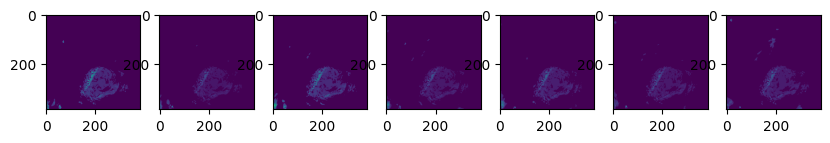

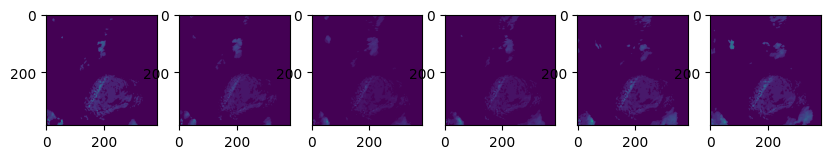

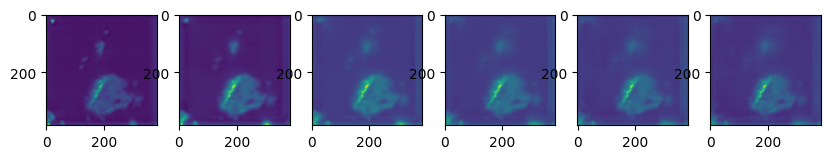

In [22]:
# visualize result
import matplotlib.pyplot as plt

def visualize(sample, seq_img):
  fig,axs=plt.subplots(1,len(seq_img),figsize=(10,5))
  for i, index in enumerate(seq_img):
    axs[i].imshow(sample[index,:,:,0])
  plt.show()

visualize(x[0], np.arange(13,step=2))
visualize(y[0], np.arange(12,step=2))
visualize(y_hat[0].detach().numpy(), np.arange(12,step=2))